In [1]:
import pandas as pd
import matplotlib
import theano
import copy
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from neupy import algorithms, layers, init, environment, plots
from neupy.exceptions import StopTraining

In [2]:
environment.reproducible() 
#environment.speedup()
learn_data=pd.read_csv("../learn_data.csv", index_col=0)
#learn_data=pd.DataFrame(learn_data, dtype='float32')
learn_data=np.array(learn_data)
validation_data=pd.read_csv("../valid_data.csv", index_col=0)
#validation_data=pd.DataFrame(validation_data, dtype='float32')
validation_data=np.array(validation_data)
test_data=pd.read_csv("../test_data.csv", index_col=0)
#test_data=pd.DataFrame(test_data, dtype='float32')
test_data=np.array(test_data)
eps=0.000001
number_of_epochs=5000

In [3]:
learn_params=learn_data[:,[0,1]]
learn_target=learn_data[:,[2]]
test_params=test_data[:,[0,1]]
test_target=test_data[:,[2]]
validation_params=validation_data[:,[0,1]]
validation_target=validation_data[:,[2]]

In [4]:
test_errors=[]
def signal(net):
    test_errors.append(((net.predict(test_params)-test_target)**2).sum()/len(test_target))
    if len(net.errors)>20:
        if abs(net.errors[len(net.errors)-1]-net.errors[len(net.errors)-2]) < eps:
            raise StopTraining("Training has been interrupted")

In [5]:
test_errors=[]
import theano.tensor as T
class Softsign(layers.ActivationLayer):
    def activation_function(self, input_value):
        return input_value/(T.abs_(input_value)+1)
bfgsnet = algorithms.QuasiNewton(
     connection=[
         layers.Input(2),
         Softsign(15, weight=init.XavierNormal(), bias=init.XavierNormal()),
         Softsign(15, weight=init.XavierNormal(), bias=init.XavierNormal()),
         Softsign(10, weight=init.XavierNormal(), bias=init.XavierNormal()),
         layers.Linear(1, weight=init.XavierNormal(), bias=init.XavierNormal()),
     ],
     update_function='bfgs',
     error='mse',
     h0_scale=1,
     epoch_end_signal=signal,
     shuffle_data=True,
     show_epoch=50,
     verbose=True
 )


Main information

[ALGORITHM] QuasiNewton

[OPTION] verbose = True
[OPTION] epoch_end_signal = signal
[OPTION] show_epoch = 50
[OPTION] shuffle_data = True
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = None
[OPTION] h0_scale = 1
[OPTION] update_function = bfgs

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 24.33 seconds


In [6]:
bfgsnet.train(learn_params, learn_target, validation_params, validation_target, epochs=number_of_epochs)


Start training

[TRAINING DATA] shapes: (4665, 2)
[TEST DATA] shapes: (2332, 2)
[TRAINING] Total epochs: 5000

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |      5.4045 |      2.2302 |       50 ms |
|          50 |     0.12511 |       0.122 |       21 ms |
|         100 |     0.12005 |     0.11951 |       20 ms |
|         150 |     0.11868 |      0.1206 |       20 ms |
|         200 |     0.11787 |     0.12134 |       20 ms |
|         250 |     0.11706 |     0.12173 |       20 ms |
|         300 |     0.11555 |     0.12228 |       25 ms |
|         350 |     0.11465 |     0.12264 |       20 ms |
|         400 |     0.11384 |     0.12157 |       21 ms |
|         450 |     0.11274 |     0.12287 |       21 ms |
|         500 |     0.11187 |     0.12247 |       20 ms |
|         550 |     0.11095 |     0.12412 |       20 ms |
|         600 |   

In [7]:
print(test_errors[-1])

0.11103266487911827


In [8]:
from sklearn import linear_model
from sklearn.metrics import r2_score
clf = linear_model.LinearRegression()
clf.fit(learn_params, learn_target)
print(clf.coef_)
print("Residual sum of squares: %.2f"
      % np.mean((clf.predict(test_params) - test_target) ** 2))


[[-0.85996233 -0.32002841]]
Residual sum of squares: 0.16


In [9]:
r2_score(test_target, clf.predict(test_params))

0.8385550413629032

In [10]:
r2_score(learn_target, clf.predict(learn_params))

0.83634586602724

Text(0.5,1,'x: learn predict y: learn target')

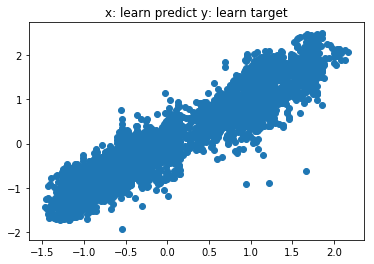

In [11]:
plt.scatter(bfgsnet.predict(learn_params),learn_target) 
plt.title('x: learn predict'+' y: learn target') 

Text(0.5,1,'x: test predict y: test target')

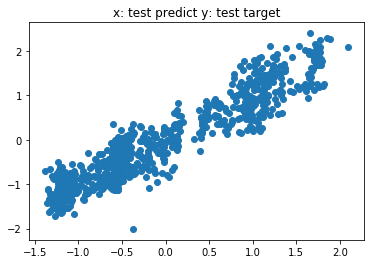

In [12]:
plt.scatter(bfgsnet.predict(test_params),test_target) 
plt.title('x: test predict'+' y: test target') 

Text(0.5,1,'x: learn predict y: learn target')

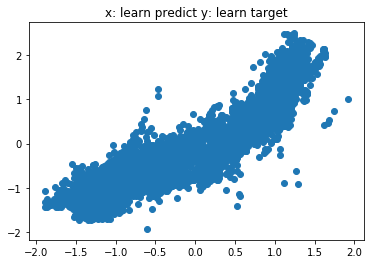

In [13]:
plt.scatter(clf.predict(learn_params),learn_target) 
plt.title('x: learn predict'+' y: learn target')

Text(0.5,1,'x: test predict y: test target')

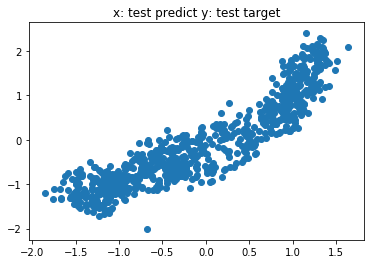

In [14]:
plt.scatter(clf.predict(test_params),test_target) 
plt.title('x: test predict'+' y: test target')

In [15]:
learn_errors=(bfgsnet.predict(learn_params)-learn_target)**2
test_errors=(bfgsnet.predict(test_params)-test_target)**2

Text(0.5,1,'learn errors')

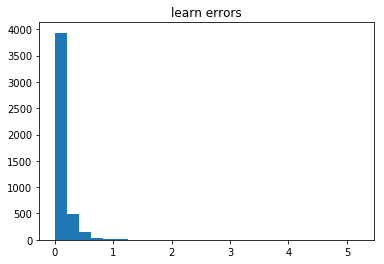

In [16]:
plt.hist(learn_errors, bins = 25)
plt.title("learn errors")

In [17]:
len(learn_errors)

4665

Text(0.5,1,'test errors')

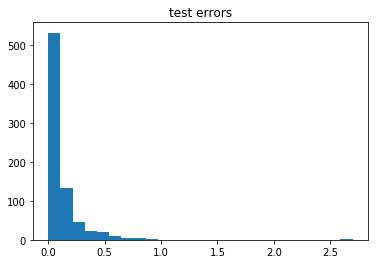

In [18]:
plt.hist(test_errors, bins = 25)
plt.title("test errors")

In [21]:
weight=bfgsnet.layers[1].weight.get_value()


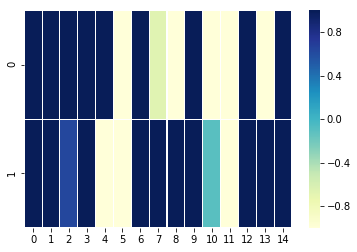

In [25]:
import seaborn as sns
#plt.figure(figsize=(40,11)) 
sns.heatmap(weight, vmin=-1, vmax=1, linewidths=0.1, cmap="YlGnBu") 

ValueError: shape mismatch: objects cannot be broadcast to a single shape

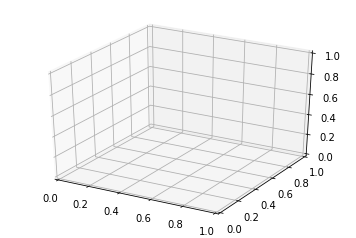

TypeError: Length of x must be number of columns in z.

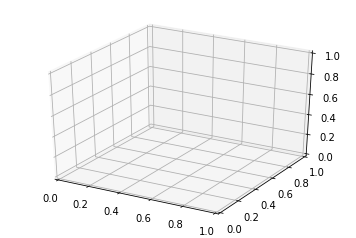

In [33]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(learn_params[1], learn_params[2], learn_data, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');